I don't know where I'm going with this, but here goes.
Let's do some experimenting!

In [1]:
# module faffery
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt



In [3]:
import asyncio as aio
import asyncio.subprocess as asp

import signal
import time
import contextlib

In [4]:
import logging
logging.basicConfig()

In [5]:
import mido

In [6]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [7]:
logging.getLogger('asyncio').setLevel(logging.WARNING)

In [8]:
def triple_open(outport):
    return aio.gather(aio.create_subprocess_exec('python', '../slurp.py', '-p', outport.name,
                                                 stdout=asp.PIPE, stderr=asp.PIPE),
                      aio.create_subprocess_exec('python', '../slurp_rtmidi.py', '-gp', outport.name,
                                                 stdout=asp.PIPE, stderr=asp.PIPE),
                      aio.create_subprocess_exec('python', '../slurp_rtmidi.py', '-P', '-gp', outport.name,
                                                 stdout=asp.PIPE, stderr=asp.PIPE),
                     )
        

def send_messages(outport, afunc):
    loop = aio.new_event_loop()
    aio.set_event_loop(loop)
    loop.set_debug(True)
        
    async def wtask():
        srp = await triple_open(outport)
        try:
            comm = aio.gather(*(p.communicate() for p in srp))
            aio.ensure_future(comm)
            await aio.sleep(0.5)
            await afunc(outport)
            await aio.sleep(0.5)
            for p in srp:
                with contextlib.suppress(ProcessLookupError):
                    p.send_signal(signal.SIGINT)
            return await comm
        except aio.CancelledError:
            for p in srp:
                with contextlib.suppress(ProcessLookupError):
                    p.terminate()
            raise


    try:
        coms = loop.run_until_complete(wtask())
        return coms
    except KeyboardInterrupt:
        # This cleanup code doesn't actually work 100% properly, but hey.
        tasks = aio.gather(*aio.Task.all_tasks())
        tasks.cancel()
        with contextlib.suppress(aio.CancelledError):
            loop.run_until_complete(tasks)
    finally:
        loop.close()




In [9]:
eport = mido.open_output('experimental', virtual=True)

midi beat clock is 24 pulses per quarter note.
A delay of 0.02 seconds works out to 125 quarter notes per minute, which is a reasonable tempo.

In [10]:
async def port_send(outport):
    for x in range(500):
        outport.send(mido.Message('clock'))
        await aio.sleep(0.02)
        

outs = send_messages(eport, port_send)

In [11]:
[x[1] for x in outs]

[b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n"]

In [12]:
message_lists = [list(mido.Message.from_str(l) for l in x[0].decode().splitlines()) for x in outs]

In [13]:
[len(l) for l in message_lists]

[500, 500, 500]

In [14]:
message_times = [np.fromiter((m.time for m in l), float, count=500) for l in message_lists]
st, rt, pt = message_times

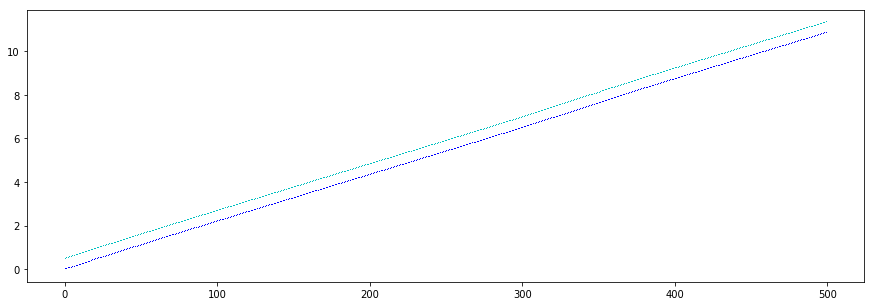

In [15]:
plt.plot(st, 'c,', rt, 'r,', pt, 'b,')
plt.show()

In [16]:
# rt and pt start counting at first message, st starts when process starts reading.
# we normalise so st starts at zero
st_norm = st - st[0]


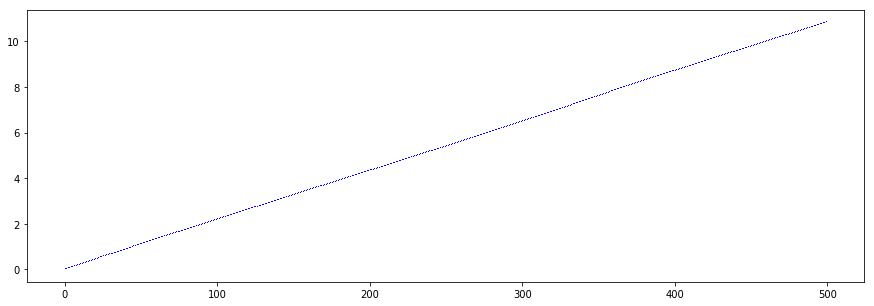

In [17]:
plt.plot(st_norm, 'c,', rt, 'r,', pt, 'b,')
plt.show()

In [18]:
ideal = np.arange(0, 500*0.02, 0.02)
# Ideally, messages would have been sent exactly every 0.02 seconds.
# however, we've been sending with gaps of 0.02 seconds, and sending takes time.

In [19]:
srpn = np.stack([st_norm, rt, pt])

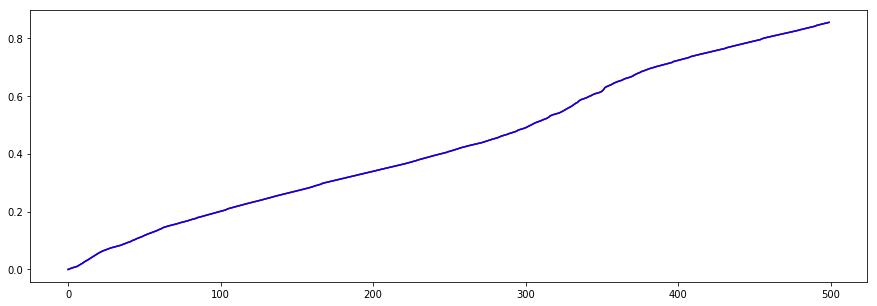

In [20]:
for x, c in zip(srpn-ideal, 'crb'):
    plt.plot(x, c)
plt.show()

In [21]:
baserange = np.arange(500)
polyfits = np.polyfit(baserange, srpn.T, 1).T


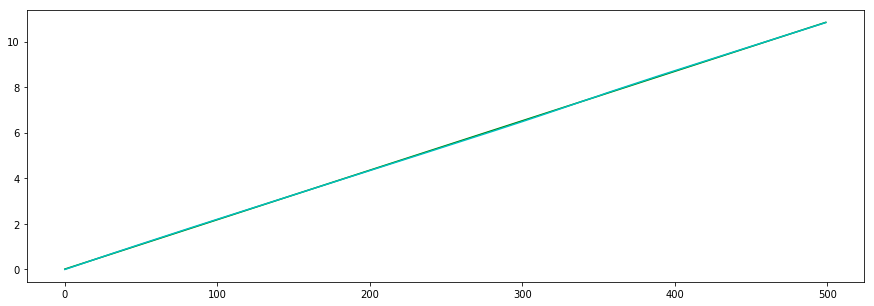

In [22]:
plt.plot(np.polyval(polyfits[0], baserange), 'g', srpn[0], 'c')
plt.show()

In [23]:
# you know what, let's just combine everything into one big set and get some sort of average fit.
avfit = np.polyfit(np.tile(baserange, 3), srpn.flatten(), 1)
avline = np.polyval(avfit, baserange)


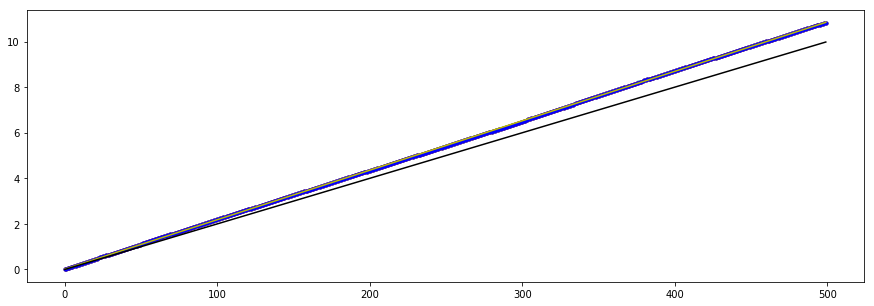

In [24]:
plt.plot(st_norm, 'c.', rt, 'r.', pt, 'b.', avline, 'y', ideal, 'k')
plt.show()

In [25]:
srpf = srpn - avline

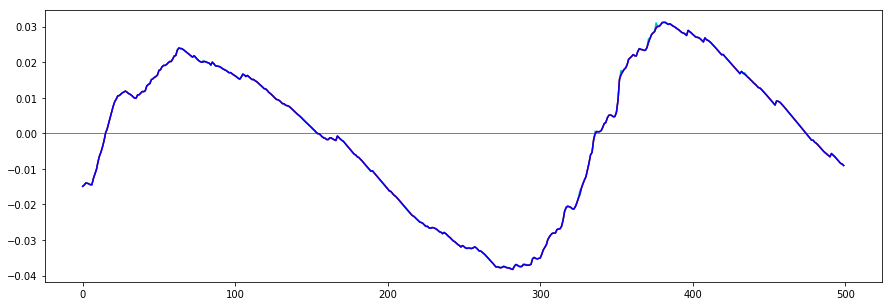

In [26]:
plt.axhline(c='grey', lw=1)
for x, c in zip(srpf, 'crb'):
    plt.plot(x, c)
plt.show()

In [27]:
# the differences.
srpd = np.diff(srpn)

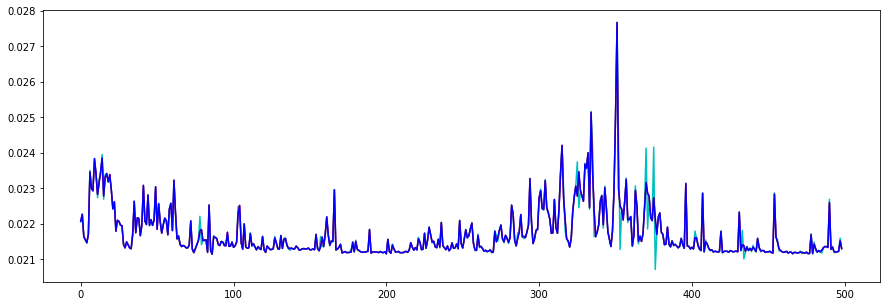

In [28]:
for x, c in zip(srpd, 'crb'):
    plt.plot(x, c)
plt.show()

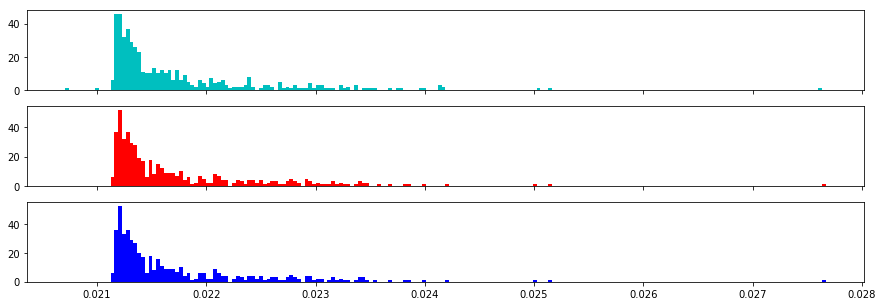

In [29]:
# Histograms!
rge = (srpd.min(), srpd.max())
fig, axes = plt.subplots(3, 1, sharex=True)
for x, c, a in zip(srpd, 'crb', axes):
    a.hist(x, color=c, bins=200, range=rge)
plt.show()

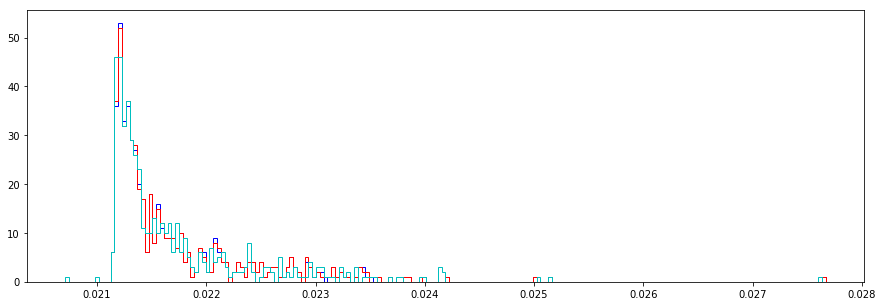

In [30]:
plt.hist(srpd.T, color='crb', bins=200, range=rge, histtype='step')
plt.show()

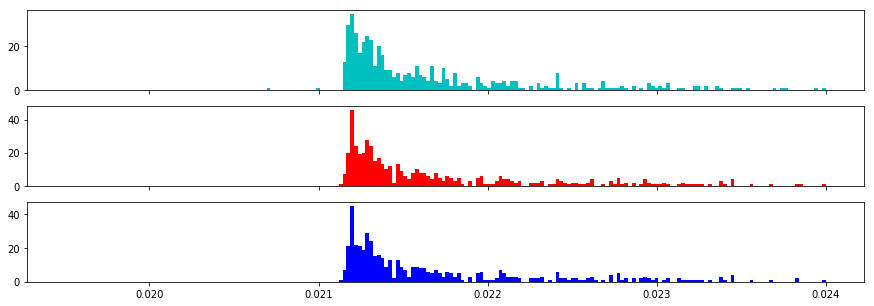

In [31]:
fig, axes = plt.subplots(3, 1, sharex=True)
for x, c, a in zip(srpd, 'crb', axes):
    a.hist(x, color=c, bins=200, range=(0.0195, 0.024))
plt.show()

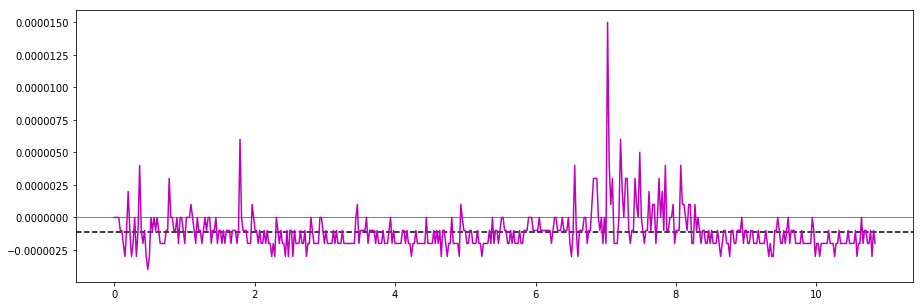

In [32]:
rpdif = rt - pt
avgt = np.mean(srpn[1:], axis=0)
plt.axhline(c='grey', lw=1)
plt.axhline(rpdif.mean(), ls='--', c='k')
plt.plot(avgt, rpdif, 'm')
plt.show()

In [33]:
# Let's try sending a lot of messages really quickly
QUIET_NOTE = mido.Message('note_on', channel=0, note=60, velocity=0)
async def rapid_send(outport):
    for x in range(500):
        outport.send(QUIET_NOTE)
        await aio.sleep(0)

In [34]:
routs = send_messages(eport, rapid_send)

In [35]:
[x[1] for x in routs]

[b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n"]

In [36]:
r_message_lists = [list(mido.Message.from_str(l) for l in x[0].decode().splitlines()) for x in routs]

In [37]:
[len(l) for l in r_message_lists]

[500, 500, 500]

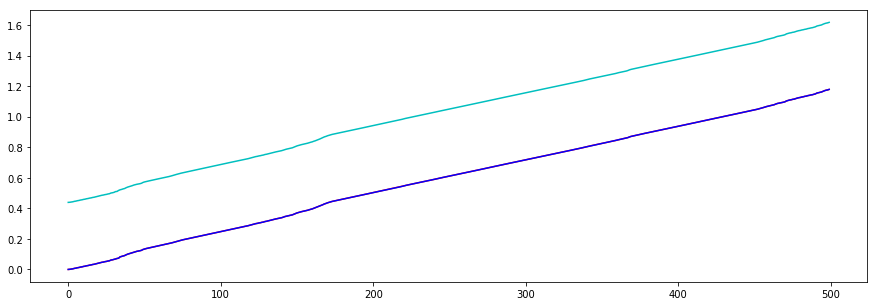

In [38]:
r_message_times = [np.fromiter((m.time for m in l), float, count=500) for l in r_message_lists]
for x, c in zip(r_message_times, 'crb'):
    plt.plot(x, c)
plt.show()

In [39]:
rdif = np.diff(r_message_times)

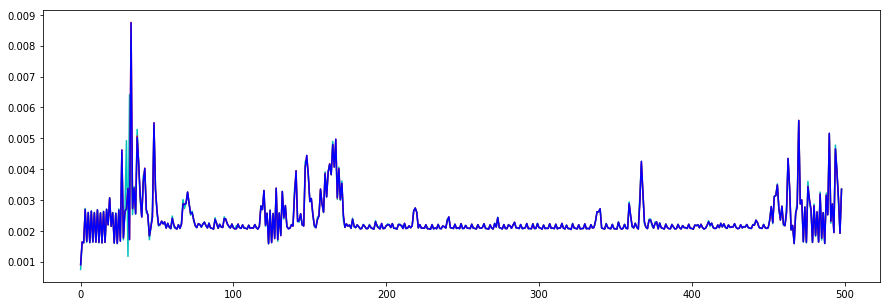

In [40]:
for x, c in zip(rdif, 'crb'):
    plt.plot(x, c)
plt.show()

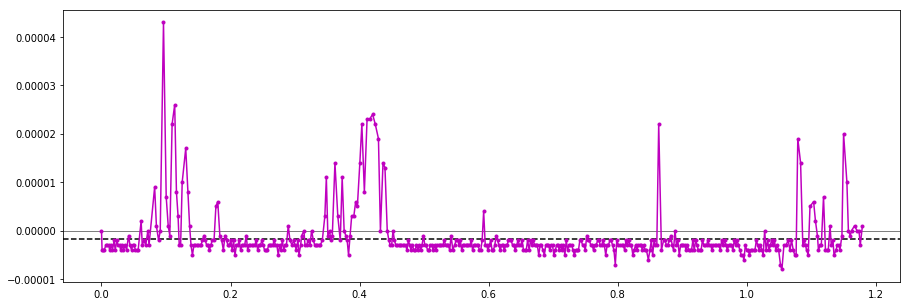

In [41]:
r_rpdif = r_message_times[1] - r_message_times[2]
r_avgt = np.mean(r_message_times[1:], axis=0)
plt.axhline(c='grey', lw=1)
plt.axhline(r_rpdif.mean(), ls='--', c='k')
plt.plot(r_avgt, r_rpdif, 'm.-')
plt.show()

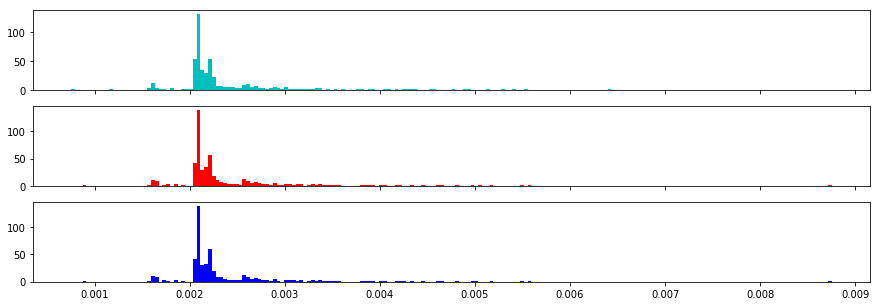

In [42]:
# Histograms!
r_rge = (rdif.min(), rdif.max())
fig, axes = plt.subplots(3, 1, sharex=True)
for x, c, a in zip(rdif, 'crb', axes):
    a.hist(x, color=c, bins=200, range=r_rge)
plt.show()

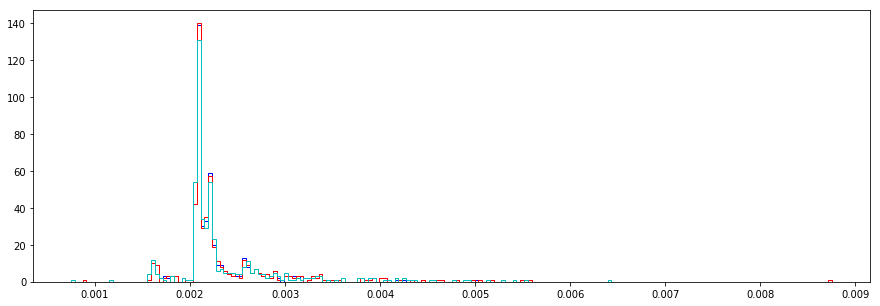

In [43]:
plt.hist(rdif.T, color='crb', bins=200, range=r_rge, histtype='step')
plt.show()

In [60]:
# what if we dump them out REALLY FAST
async def really_rapid_send(outport):
    for x in range(500):
        outport.send(QUIET_NOTE)
    await aio.sleep(0)


In [61]:
rrouts = send_messages(eport, really_rapid_send)

In [62]:
[x[1] for x in rrouts]

[b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\n\nMidiInAlsa::alsaMidiHandler: unknown MIDI input error!\nSystem reports: Resource temporarily unavailable\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n"]

Looks like we overhelmed the callback buffers?

In [63]:
rr_message_lists = [list(mido.Message.from_str(l) for l in x[0].decode().splitlines()) for x in rrouts]
[len(l) for l in rr_message_lists]

[536, 300, 536]

... how did we get more than 500 messages??

In [64]:
[all(x.type == 'note_on' and x.channel == 0 and x.note == 60 for x in l) for l in rr_message_lists]

[True, True, True]

In [74]:
# what if we dump them out REALLY FAST
async def ascend_send(outport):
    for x in range(5):
        for y in range(100):
            outport.send(mido.Message('note_on', channel=x, note=y, velocity=0))
    aio.sleep(0)


In [75]:
a_outs = send_messages(eport, ascend_send)

In [76]:
[x[1] for x in a_outs]

[b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\n\nMidiInAlsa::alsaMidiHandler: unknown MIDI input error!\nSystem reports: Resource temporarily unavailable\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n"]

In [77]:
a_message_lists = [list(mido.Message.from_str(l) for l in x[0].decode().splitlines()) for x in a_outs]
[len(l) for l in a_message_lists]

[531, 300, 531]

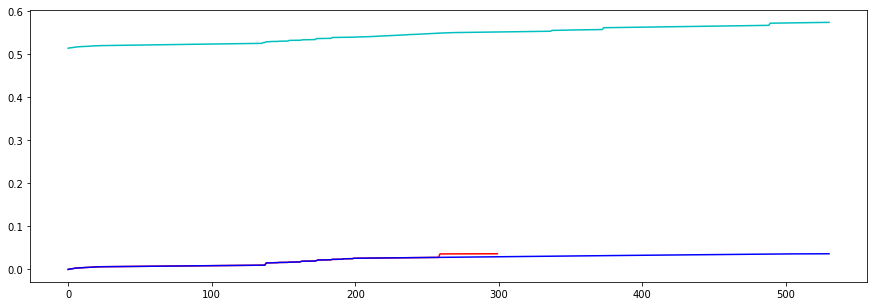

In [78]:
a_message_times = [np.fromiter((m.time for m in l), float) for l in a_message_lists]
for x, c in zip(a_message_times, 'crb'):
    plt.plot(x, c)
plt.show()


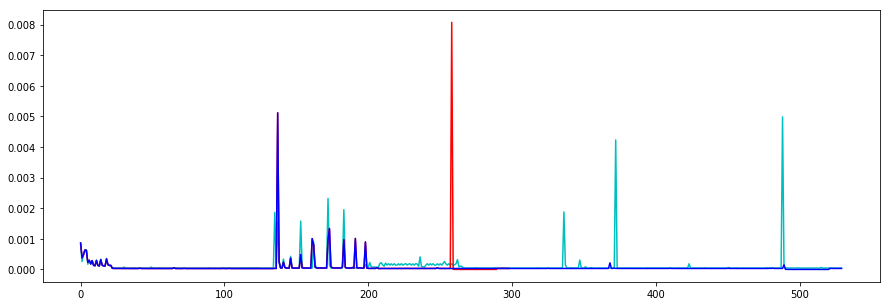

In [79]:
for x, c in zip(a_message_times, 'crb'):
    plt.plot(np.diff(x), c)
plt.show()

Pretty, but I have no idea what this really means

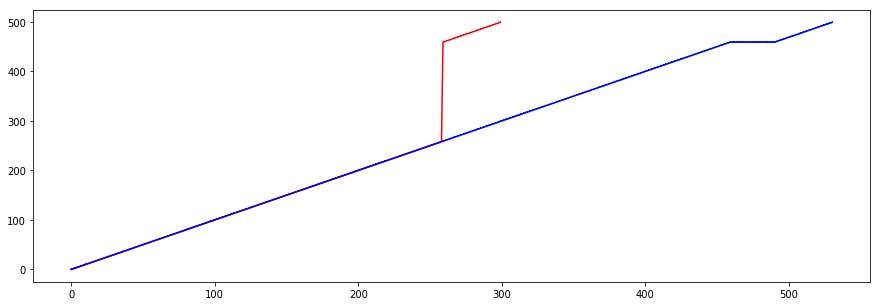

In [89]:
a_message_ctr = [np.fromiter((100*m.channel + m.note for m in l), float) for l in a_message_lists]
for  x, c in zip(a_message_ctr, 'crb'):
    plt.plot(x, c+',-')
plt.show()

Looks like the callback dropped a bunch of messages and the poll and mido-queue powered one repeated a bunch of methods.
I guess unpredictable things happen when you overload the midi buffer

In [94]:
async def pulse_send(outport):
    for x in range(50):
        for y in range(10):
            outport.send(QUIET_NOTE)
        await aio.sleep(0.01)

In [96]:
p_outs = send_messages(eport, pulse_send)

In [97]:
[x[1] for x in p_outs]

[b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n",
 b"Reading from port 'RtMidiOut Client:experimental 128:0'. CtrlC to stop\nStopping on KeyboardInterrupt\n"]

In [98]:
p_message_lists = [list(mido.Message.from_str(l) for l in x[0].decode().splitlines()) for x in p_outs]
[len(l) for l in p_message_lists]

[500, 500, 500]

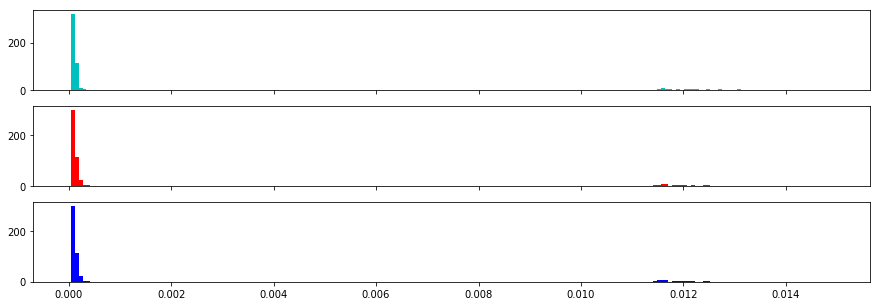

In [106]:
p_times = [np.fromiter((m.time for m in l), float) for l in p_message_lists]
p_diff = np.diff(p_times)
p_rge = (p_diff.min(), p_diff.max())
fig, axes = plt.subplots(3, 1, sharex=True)
for x, c, a in zip(p_diff, 'crb', axes):
    a.hist(x, color=c, bins=200, range=p_rge)
plt.show()

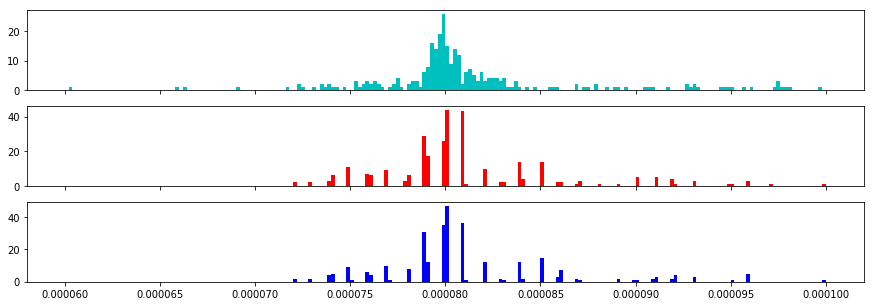

In [113]:
fig, axes = plt.subplots(3, 1, sharex=True)
for x, c, a in zip(p_diff, 'crb', axes):
    a.hist(x, color=c, bins=200, range=(6e-5, 10e-5))
plt.show()